In [1]:
import numpy as np
from hamiltonian import *
from reconstruct_lcu import *
from continuers import *
from qsearch_bundle_circuit import *
import pickle

In [2]:
def crossings(J,Bzmax,N,pbc=True,resolution=300):
    cross_points=np.zeros(N)
    Bzlist = np.linspace(0,Bzmax,resolution)
    eval_store = np.zeros([len(Bzlist),2**N])
    diff=0.0
    i=0
    for iBz,Bz in enumerate(Bzlist):
        ham= XY_hamiltonian(J,0.0,Bz,N,pbc)
        eval_store[iBz,:] = np.linalg.eigvalsh(ham)
        diff = eval_store[iBz,0]- eval_store[iBz,1]
        #print(diff)
        if np.absolute(diff) < 0.02 :
            cross_points[i]=Bzlist[iBz]
            i=i+1
            print('crossing point', Bzlist[iBz])
    
                  
    for ip in range(N-1):
        diff= cross_points[ip]-cross_points[ip+1]
        if np.absolute(diff)< 0.1:
            cross_points[ip+1]=0                
        
    return cross_points

import numpy as np
from scipy.signal import argrelextrema

def get_crossings(J,Bzmax,N,pbc=False,resolution=300):
    # cross_points=np.zeros(N)
    Bzlist = np.linspace(0,Bzmax,resolution)
    eval_store = np.zeros([len(Bzlist),2**N])
    diff= np.zeros_like(Bzlist)
    
    for iBz,Bz in enumerate(Bzlist):
        ham= XY_hamiltonian(J,0.0,Bz,N,pbc)
        eval_store[iBz,:] = np.linalg.eigvalsh(ham)
        diff[iBz] = eval_store[iBz,1]- eval_store[iBz,0]
    cross_points_ind = argrelextrema(diff, np.less)
    cross_points = np.zeros_like(cross_points_ind)
    cross_points = Bzlist[cross_points_ind]
    return cross_points

def test_crossings(N=8):
    # cross_points  = crossings(J=-1,Bzmax=4.0,N=N)   
    # print(cross_points)
    cross_points  = get_crossings(J=-1,Bzmax=4.0,N=N)   
    print(cross_points)

test_crossings()

[0.34782609 1.00334448 1.53846154 1.8729097 ]


In [134]:
def fivesitesexperiments(Bzmax=4,write=False):
    J = -1
    Bx = 0.1
    N = 5
    pbc = False

    fig, ax, Bzlist, eval_stor = show_XY_spectrum(N=N, Bzmin=0, Bzmax=Bzmax, Bx=Bx, J=J, pbc=pbc)
  
    Bzlist_training = [0.5, 1.3]
    # Bzlist_training = [0.5, 1.3, 1.8]
    # Bzlist_training = [0.5, 1.3, 2.1]
    training_paramlist = [[J, Bx, Bz, N, pbc] for Bz in Bzlist_training]
    # _qc for passing parameters to the quantum circuit, because I prefer dictionaries than lists
    training_paramlist_qc = [{"J": J, "Bx": Bx, "Bz": Bz, "N": N, "pbc": pbc} for Bz in Bzlist_training]

    if 'ax' in locals():
        for b in Bzlist_training:
            ax.axvline(b)

  
    # Bzlist_target = [0.3, 0.5, 0.7, 1.1, 1.5, 1.7, 1.9]
    
    Bzlist_target = np.linspace(0.0,Bzmax,10)

    target_paramlist = [[J, Bx, Bz, N, pbc] for Bz in Bzlist_target]
    # target_paramlist_qc = [{"J": J, "Bx": Bx, "Bz": Bz, "N": N, "pbc": pbc} for Bz in Bzlist_target]
    #################### INPUT parameters over ######################################

    # Object that knows how to deal with the various operations needed
    vectorspace = vector_methods(XY_hamiltonian)


    EVcontinuer = vector_continuer(vectorspace,
                                   XY_hamiltonian,
                                   Mag_op,
                                   training_paramlist,
                                   target_paramlist,
                                   N)

    EVcontinuer.get_base_eigenvectors()
   
    EVcontinuer.get_target_eigenvectors(ortho=False)   
    if 'ax' in locals():
        for ip in range(len(training_paramlist)):
            ax.plot(Bzlist_target, np.real(EVcontinuer.target_evals[:, ip]), 'o', color="b")
            
    if(write):
        data_exactlist = [Bzlist]
        frmt = ['%f']
        for i in range(2**N):
            data_exactlist.append(eval_stor[:,i])
            frmt.append('%f')
        data_exact = np.array(data_exactlist)
        # data_exact = np.array([Jzlist,eval_stor_tot[:,0],eval_stor_tot[:,1],eval_stor_tot[:,2], eval_stor_tot[:,3]])
        data_exact = data_exact.T
        filenameExact="paper_figures/plot_data/BasisComp_Exact_energyN="+str(N)+"_npoints="+str(100)+".dat"
        np.savetxt(filenameExact, data_exact, fmt=frmt)
        
        
            ####################
        data_edlist = [Bzlist_target]
        frmt = ['%f']
        for j in range(len(Bzlist_training)):
                data_edlist.append(np.real(EVcontinuer.target_evals[:,j]))
                frmt.append('%f')
        data_ed = np.array(data_edlist)
            # print(EVcontinuer.target_evals[:,0],EVcontinuer.target_evals[:,1])
        data_ed  = data_ed.T
        filenameed="paper_figures/plot_data/BasisComp_ed_energyN="+str(N)+str(Bzlist_training)+"lentarget="+str(len(Bzlist_target)) +".dat"
        np.savetxt(filenameed, data_ed, fmt=frmt)
        
        #####################
      
        EVcontinuertemp = vector_continuer(vectorspace,
                                   XY_hamiltonian,
                                   Mag_op,
                                   training_paramlist,
                                   training_paramlist,
                                   N)
        EVcontinuertemp.get_base_eigenvectors()
        EVcontinuertemp.get_target_eigenvectors(ortho=False)
        
        frmt = ['%f','%f']
        E_trlist = []
        for i in range(len(Bzlist_training)):
            E_trlist.append(np.real(EVcontinuertemp.target_evals[i,0]))
            # frmt.append('%f')
        data_trlist = [Bzlist_training,E_trlist]
        data_tr = np.array(data_trlist)
        data_tr  = data_tr.T
        filenametr="paper_figures/plot_data/BasisComp_trainingN="+str(N)+str(Bzlist_training)+".dat"
        np.savetxt(filenametr, data_tr, fmt=frmt)
                       
        # cross_points  = crossings(J=J,Bzmax=Bzmax,N=N,pbc=pbc)
        cross_points  = get_crossings(J=J,Bzmax=Bzmax,N=N,pbc=pbc,resolution=500)
        frmt = ['%f']
        data_crlist = [cross_points]
        data_cr = np.array(data_crlist)
        data_cr  = data_cr.T
        filenamecr="paper_figures/plot_data/BasisComp_crossingN="+str(N)+".dat"
        np.savetxt(filenamecr, data_cr, fmt=frmt)

[-1, 0.1, 0.5, 5, False]
Adding vector for parameter set [-1, 0.1, 0.5, 5, False]
[-1, 0.1, 1.3, 5, False]
Adding vector for parameter set [-1, 0.1, 1.3, 5, False]

[-1, 0.1, 0.5, 5, False]
Adding vector for parameter set [-1, 0.1, 0.5, 5, False]
[-1, 0.1, 1.3, 5, False]
Adding vector for parameter set [-1, 0.1, 1.3, 5, False]



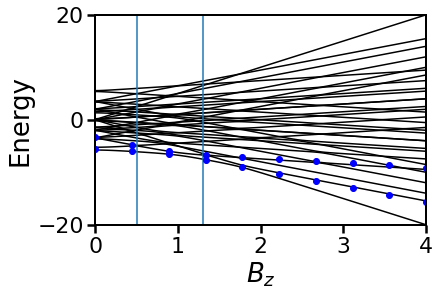

In [135]:
fivesitesexperiments(Bzmax=4,write=True)

In [3]:
def read_plotdata_lcu_exactenergy(filename,ncol=5):
    filename = "paper_figures/plot_data/" +filename
    cols = tuple(range(0,ncol))
        
    data = np.genfromtxt(filename, usecols=cols)
    data = data.T
    # print(data)
    Bzlist = data[0]
    eval_stor = np.zeros([len(Bzlist),ncol-1])
    for i in range(ncol-1):
        eval_stor[:,i] = data[i+1]
    
    return Bzlist,eval_stor
def read_plotdata_lcu_train(filename,ncol=2):
    filename = "paper_figures/plot_data/" +filename
    cols = tuple(range(0,ncol))
        
    data = np.genfromtxt(filename, usecols=cols)
    data = data.T
    # print(data)
    Bzlist = data[0]
    evals = data[1]
    
      
    return Bzlist,evals

In [38]:
def fivesitesexperiments_plot1(fig,ax):
    N=5
    Bzlist_training = [0.5, 1.3]
    filename_exact = "BasisComp_Exact_energyN=5_npoints=100.dat"    
    Bzlist,eval_stor = read_plotdata_lcu_exactenergy(filename = filename_exact,ncol=2**5+1)
    
    for j in range(2**N):
        if(j==0):
            ax.plot(Bzlist,eval_stor[:,j],color="k",lw=2) 
        else:
            ax.plot(Bzlist,eval_stor[:,j],color="k",alpha=0.2) 
    filename_ed = "BasisComp_ed_energyN=5"+str(Bzlist_training)+"lentarget=10.dat"
    Bzlist_ed,eval_stor_ed = read_plotdata_lcu_exactenergy(filename = filename_ed,ncol=3)
    for j in range(2):
        if(j==0):
            ax.plot(Bzlist_ed,eval_stor_ed[:,j],color="b",marker="o",markersize=4,label="EC") 
        else:
            ax.plot(Bzlist_ed,eval_stor_ed[:,j],color="b",marker="o",markersize=4,alpha=0.5) 
    ################################
    filename_BCtr = "BasisComp_trainingN=5[0.5, 1.3].dat"        
    Bzlist_tr, Elisttr = read_plotdata_lcu_train(filename=filename_BCtr,ncol=2)
    # ax.plot(Bzlist_tr,Elisttr,'s',color = "r",fillstyle = "left",markersize = 10,label = "Training points")
    ax.plot(Bzlist_tr,Elisttr,'s',color = "r",fillstyle = "left",markersize = 10,)
    
    ymin, ymax = ax.get_ybound()
    for j in range(len(Bzlist_tr)):
        ax.axvline(Bzlist_tr[j],ymax = (Elisttr[j]-ymin)/(ymax-ymin),ymin=0.09,ls="--",color="r")
        ax.text(Bzlist_tr[j]-0.1,-19.1,str(Bzlist_tr[j]), fontsize='15')
    # ax.text(Bzlist_tr[1]-0.1,-22.0,str(Bzlist_tr[1]), fontsize='15')
    # ax.text(Bzlist_tr[2],-20.5, str(Bzlist_tr[2]),fontsize='15')
    #####################################
    filename_BcCr = "BasisComp_crossingN=5.dat"        
    filename_BcCr = "paper_figures/plot_data/" + filename_BcCr
    data = np.genfromtxt(filename_BcCr)
    data = data.T
    # print(data)
    crossings = data
    print(crossings)
    col1=(0.0,0.5,0.5,0.05)
    col2=(0.0,0.5,0.5,0.1)
    col3=(0.0,0.5,0.5,0.2)
    # ax.axvspan(0.0, crossings[1], facecolor=col1)
    # ax.axvspan(crossings[1], crossings[2], facecolor=col2)
    # ax.axvspan(crossings[2], 6.0, facecolor=col3)
    ax.axvspan(0.0, crossings[0], facecolor=col1)
    ax.axvspan(crossings[0], crossings[1], facecolor=col2)
    ax.axvspan(crossings[1], 4.0, facecolor=col3)
    l=ax.legend(loc=2,fontsize=12)
    l.get_frame().set_alpha(0)
    ax.set_yticks([20,0])
    # ax.set_ylim(-19.9,20)
    fig.text(-0.05, 0.5, r"$ Energy[J] $", va='center', ha='center', rotation='vertical', fontsize=plt.rcParams['axes.labelsize'])

In [39]:
# def fivesitesexperiments_plot1(fig,ax):
#     N=5
#     filename_exact = "BasisComp_Exact_energyN=5_npoints=100.dat"    
#     Bzlist,eval_stor = read_plotdata_lcu_exactenergy(filename = filename_exact,ncol=2**5+1)
    
#     for j in range(2**N):
#         if(j==0):
#             ax.plot(Bzlist,eval_stor[:,j],color="k",lw=2) 
#         else:
#             ax.plot(Bzlist,eval_stor[:,j],color="k",alpha=0.2) 
#     filename_ed = "BasisComp_ed_energyN=5"+str(Bzlist_training)+"lentarget=10.dat"
#     Bzlist_ed,eval_stor_ed = read_plotdata_lcu_exactenergy(filename = filename_ed,ncol=3)
#     for j in range(2):
#         if(j==0):
#             ax.plot(Bzlist_ed,eval_stor_ed[:,j],color="b",marker="o",markersize=4) 
#         else:
#             ax.plot(Bzlist_ed,eval_stor_ed[:,j],color="b",marker="o",markersize=4,alpha=0.5) 
#     ################################
#     filename_BCtr = "BasisComp_training"+str(Bzlist_training)+".dat"        
#     Bzlist_tr, Elisttr = read_plotdata_lcu_train(filename=filename_BCtr,ncol=2)
#     ax.plot(Bzlist_tr,Elisttr,'s',color = "r",fillstyle = "left",markersize = 10,label = "Training points")
    
#     ymin, ymax = ax.get_ybound()
#     for j in range(2):
#         ax.axvline(Bzlist_tr[j],ymax = (Elisttr[j]-ymin)/(ymax-ymin),ymin=0.09,ls="--",color="r")
#     ax.text(Bzlist_tr[0]-0.1,-29.0,str(Bzlist_tr[0]), fontsize='15')
#     ax.text(Bzlist_tr[1]-0.1,-29.0,str(Bzlist_tr[1]), fontsize='15')
#     # ax.text(Bzlist_tr[2],-20.5, str(Bzlist_tr[2]),fontsize='15')
#     #####################################
#     filename_BcCr = "BasisComp_crossingN=5"+str(Bzlist_training)+".dat"        
#     filename_BcCr = "paper_figures/plot_data/" + filename_BcCr
#     data = np.genfromtxt(filename_BcCr)
#     data = data.T
#     # print(data)
#     crossings = data
#     print(crossings)
#     col1=(0.0,0.5,0.5,0.05)
#     col2=(0.0,0.5,0.5,0.1)
#     col3=(0.0,0.5,0.5,0.2)
#     ax.axvspan(0.0, crossings[1], facecolor=col1)
#     ax.axvspan(crossings[1], crossings[2], facecolor=col2)
#     ax.axvspan(crossings[2], 6.0, facecolor=col3)
    
#     fig.text(-0.05, 0.5, r"$ Energy[J] $", va='center', ha='center', rotation='vertical', fontsize=plt.rcParams['axes.labelsize'])

In [40]:
def fivesitesexperiments_plot2(fig,ax):
    N=5
    filename_exact = "BasisComp_Exact_energyN=5_npoints=100.dat"    
    Bzlist,eval_stor = read_plotdata_lcu_exactenergy(filename = filename_exact,ncol=2**N+1)
    Bzlist_training = [0.5, 1.3, 1.8]
    for j in range(2**N):
        if(j==0):
            ax.plot(Bzlist,eval_stor[:,j],color="k",lw=2,label="Exact") 
        else:
            ax.plot(Bzlist,eval_stor[:,j],color="k",alpha=0.2) 
    filename_ed = "BasisComp_ed_energyN=5"+str(Bzlist_training)+"lentarget=10.dat"
    Bzlist_ed,eval_stor_ed = read_plotdata_lcu_exactenergy(filename = filename_ed,ncol=len(Bzlist_training)+1)
    for j in range(len(Bzlist_training)):
        if(j==0):
            ax.plot(Bzlist_ed,eval_stor_ed[:,j],color="b",marker="o",markersize=4) 
        else:
            ax.plot(Bzlist_ed,eval_stor_ed[:,j],color="b",marker="o",markersize=4,alpha=0.5) 
    ################################
    filename_BCtr = "BasisComp_trainingN=5"+str(Bzlist_training)+".dat"        
    Bzlist_tr, Elisttr = read_plotdata_lcu_train(filename=filename_BCtr,ncol=2)
    ax.plot(Bzlist_tr,Elisttr,'s',color = "r",fillstyle = "left",markersize = 10,label = "Training points")
    
    ymin, ymax = ax.get_ybound()
    for j in range(len(Bzlist_tr)):
        ax.axvline(Bzlist_tr[j],ymax = (Elisttr[j]-ymin)/(ymax-ymin),ymin=0.09,ls="--",color="r")
        ax.text(Bzlist_tr[j]-0.1,-19.1,str(Bzlist_tr[j]), fontsize='15')
   
    #####################################
    filename_BcCr = "BasisComp_crossingN=5.dat"        
    filename_BcCr = "paper_figures/plot_data/" + filename_BcCr
    data = np.genfromtxt(filename_BcCr)
    data = data.T
    # print(data)
    crossings = data
    print(crossings)
    col1=(0.0,0.5,0.5,0.05)
    col2=(0.0,0.5,0.5,0.1)
    col3=(0.0,0.5,0.5,0.2)
    ax.axvspan(0.0, crossings[0], facecolor=col1)
    ax.axvspan(crossings[0], crossings[1], facecolor=col2)
    ax.axvspan(crossings[1], 4.0, facecolor=col3)
    
    fig.text(-0.05, 0.5, r"$ Energy[J] $", va='center', ha='center', rotation='vertical', fontsize=plt.rcParams['axes.labelsize'])
    # ax.set_yticks([20,0,-20])
    ax.set_xlabel(r"$B_z$")
    l=ax.legend(loc=2,fontsize=12)
    l.get_frame().set_alpha(0)

/home/akhil/anaconda3/envs/h2/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  This is separate from the ipykernel package so we can avoid doing imports until


[1.002004 1.731463]
[1.002004 1.731463]


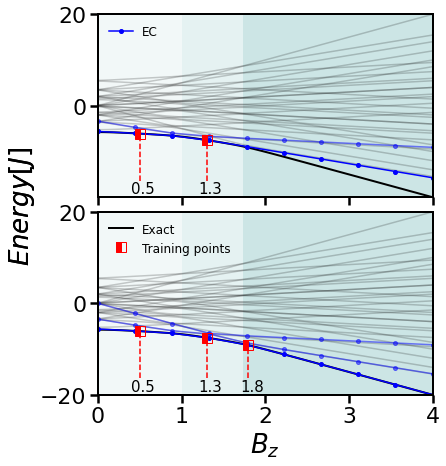

In [46]:
def fivesitesexperiments_plot_tog():
    fig,ax = plt.subplots(figsize=(6,3.5*2),nrows =2,ncols=1,sharex=True)
    fig.subplots_adjust(wspace=0.0,hspace=0.08)
    fivesitesexperiments_plot1(fig=fig,ax=ax[0])    
    fivesitesexperiments_plot2(fig=fig,ax=ax[1])   
    tag = "N=5BS_v1"
    fignamepdf = "paper_figures/paper_plots/" + tag + ".pdf"
    fig.savefig(fignamepdf,bbox_inches='tight')
    fignamepng = "paper_figures/paper_plots/" + tag + ".png"
    fig.savefig(fignamepng,bbox_inches='tight')
fivesitesexperiments_plot_tog()

In [145]:
# def fivesitesexperiments_plot(N=5):
#     filename_exact = "BasisComp_Exact_energyN=5_npoints=100.dat"    
#     Bzlist,eval_stor = read_plotdata_lcu_exactenergy(filename = filename_exact,ncol=2**5+1)
#     fig,ax = plt.subplots(nrows =1,sharex=True)
#     for j in range(2**N):
#         if(j==0):
#             ax.plot(Bzlist,eval_stor[:,j],color="k",lw=2) 
#         else:
#             ax.plot(Bzlist,eval_stor[:,j],color="k",alpha=0.2) 
#     filename_ed = "BasisComp_ed_energyN=5[0.5, 1.3]lentarget=10.dat"
#     Bzlist_ed,eval_stor_ed = read_plotdata_lcu_exactenergy(filename = filename_ed,ncol=3)
#     for j in range(2):
#         if(j==0):
#             ax.plot(Bzlist_ed,eval_stor_ed[:,j],color="b",marker="o",markersize=4) 
#         else:
#             ax.plot(Bzlist_ed,eval_stor_ed[:,j],color="b",marker="o",markersize=4,alpha=0.5) 
#     ################################
#     filename_BCtr = "BasisComp_training[0.5, 1.3].dat"        
#     Bzlist_tr, Elisttr = read_plotdata_lcu_train(filename=filename_BCtr,ncol=2)
#     ax.plot(Bzlist_tr,Elisttr,'s',color = "r",fillstyle = "left",markersize = 10,label = "Training points")
    
#     ymin, ymax = ax.get_ybound()
#     for j in range(2):
#         ax.axvline(Bzlist_tr[j],ymax = (Elisttr[j]-ymin)/(ymax-ymin),ymin=0.09,ls="--",color="r")
#     ax.text(Bzlist_tr[0]-0.1,-29.0,str(Bzlist_tr[0]), fontsize='15')
#     ax.text(Bzlist_tr[1]-0.1,-29.0,str(Bzlist_tr[1]), fontsize='15')
#     # ax.text(Bzlist_tr[2],-20.5, str(Bzlist_tr[2]),fontsize='15')
#     #####################################
#     filename_BcCr = "BasisComp_crossingN=5[0.5, 1.3].dat"        
#     filename_BcCr = "paper_figures/plot_data/" + filename_BcCr
#     data = np.genfromtxt(filename_BcCr)
#     data = data.T
#     # print(data)
#     crossings = data
#     print(crossings)
#     col1=(0.0,0.5,0.5,0.05)
#     col2=(0.0,0.5,0.5,0.1)
#     col3=(0.0,0.5,0.5,0.2)
#     ax.axvspan(0.0, crossings[1], facecolor=col1)
#     ax.axvspan(crossings[1], crossings[2], facecolor=col2)
#     ax.axvspan(crossings[2], 6.0, facecolor=col3)
    
#     fig.text(-0.05, 0.5, r"$ Energy[J] $", va='center', ha='center', rotation='vertical', fontsize=plt.rcParams['axes.labelsize'])
    
# fivesitesexperiments_plot()

In [146]:
# def eightsitesexperiments(Bzmax=4):
#     J = -1
#     Bx = 0.1
#     N = 8
#     pbc = False

#     fig, ax, Bzlist, eval_stor = show_XY_spectrum(N=N, Bzmin=0, Bzmax=Bzmax, Bx=Bx, J=J, pbc=pbc)
  
#     Bzlist_training = [0.1, 1.3]
#     Bzlist_training = [0.5, 1.3, 1.8]
#     training_paramlist = [[J, Bx, Bz, N, pbc] for Bz in Bzlist_training]
#     # _qc for passing parameters to the quantum circuit, because I prefer dictionaries than lists
#     training_paramlist_qc = [{"J": J, "Bx": Bx, "Bz": Bz, "N": N, "pbc": pbc} for Bz in Bzlist_training]

#     if 'ax' in locals():
#         for b in Bzlist_training:
#             ax.axvline(b)

  
#     # Bzlist_target = [0.3, 0.5, 0.7, 1.1, 1.5, 1.7, 1.9]
    
#     Bzlist_target = np.linspace(0.0,4.0,10)

#     target_paramlist = [[J, Bx, Bz, N, pbc] for Bz in Bzlist_target]
#     target_paramlist_qc = [{"J": J, "Bx": Bx, "Bz": Bz, "N": N, "pbc": pbc} for Bz in Bzlist_target]
#     #################### INPUT parameters over ######################################

#     # Object that knows how to deal with the various operations needed
#     vectorspace = vector_methods(XY_hamiltonian)


#     EVcontinuer = vector_continuer(vectorspace,
#                                    XY_hamiltonian,
#                                    Mag_op,
#                                    training_paramlist,
#                                    target_paramlist,
#                                    N)

#     EVcontinuer.get_base_eigenvectors()
   
#     EVcontinuer.get_target_eigenvectors(ortho=False)   
#     if 'ax' in locals():
#         for ip in range(len(training_paramlist)):
#             ax.plot(Bzlist_target, np.real(EVcontinuer.target_evals[:, ip]), 'o', color="b")
  

In [147]:
# eightsitesexperiments(Bzmax=4)

In [192]:
def eightsitesexperiments(Bzmax=4,write=False):
    J = -1
    Bx = 0.1
    N = 8
    pbc = False

    fig, ax, Bzlist, eval_stor = show_XY_spectrum(N=N, Bzmin=0, Bzmax=Bzmax, Bx=Bx, J=J, pbc=pbc)
  
    
    # Bzlist_training = [0.0, 0.5, 1.3, 1.7, 1.95]
    # [0.34782609 1.00334448 1.53846154 1.8729097 ]
    # [0.40133779 1.13712375 1.69899666 2.00668896]
    # Bzlist_training = [0.2, 0.5, 1.3,]
    Bzlist_training = [0.2, 0.5, 1.3, 1.7]
    # Bzlist_training = [0.2, 0.5, 1.3, 1.7,1.9]
    
    training_paramlist = [[J, Bx, Bz, N, pbc] for Bz in Bzlist_training]
    # _qc for passing parameters to the quantum circuit, because I prefer dictionaries than lists
    training_paramlist_qc = [{"J": J, "Bx": Bx, "Bz": Bz, "N": N, "pbc": pbc} for Bz in Bzlist_training]

    if 'ax' in locals():
        for b in Bzlist_training:
            ax.axvline(b)

  
    # Bzlist_target = [0.3, 0.5, 0.7, 1.1, 1.5, 1.7, 1.9]
    
    Bzlist_target = np.linspace(0.0,Bzmax,10)

    target_paramlist = [[J, Bx, Bz, N, pbc] for Bz in Bzlist_target]
    # target_paramlist_qc = [{"J": J, "Bx": Bx, "Bz": Bz, "N": N, "pbc": pbc} for Bz in Bzlist_target]
    #################### INPUT parameters over ######################################

    # Object that knows how to deal with the various operations needed
    vectorspace = vector_methods(XY_hamiltonian)


    EVcontinuer = vector_continuer(vectorspace,
                                   XY_hamiltonian,
                                   Mag_op,
                                   training_paramlist,
                                   target_paramlist,
                                   N)

    EVcontinuer.get_base_eigenvectors()
   
    EVcontinuer.get_target_eigenvectors(ortho=False)   
    if 'ax' in locals():
        for ip in range(len(training_paramlist)):
            ax.plot(Bzlist_target, np.real(EVcontinuer.target_evals[:, ip]), 'o', color="b")
            
    if(write):
        # data_exactlist = [Bzlist]
        # frmt = ['%f']
        # for i in range(2**N):
        #     data_exactlist.append(eval_stor[:,i])
        #     frmt.append('%f')
        # data_exact = np.array(data_exactlist)
        # data_exact = data_exact.T
        # filenameExact="paper_figures/plot_data/BasisComp_Exact_energyN="+str(N)+"_npoints="+str(100)+".dat"
        # np.savetxt(filenameExact, data_exact, fmt=frmt)
        
        
            ####################
        data_edlist = [Bzlist_target]
        frmt = ['%f']
        for j in range(len(Bzlist_training)):
                data_edlist.append(np.real(EVcontinuer.target_evals[:,j]))
                frmt.append('%f')
        data_ed = np.array(data_edlist)
            # print(EVcontinuer.target_evals[:,0],EVcontinuer.target_evals[:,1])
        data_ed  = data_ed.T
        filenameed="paper_figures/plot_data/BasisComp_ed_energyN="+str(N)+str(Bzlist_training)+"lentarget="+str(len(Bzlist_target)) +".dat"
        np.savetxt(filenameed, data_ed, fmt=frmt)
        
        #####################
      
        EVcontinuertemp = vector_continuer(vectorspace,
                                   XY_hamiltonian,
                                   Mag_op,
                                   training_paramlist,
                                   training_paramlist,
                                   N)
        EVcontinuertemp.get_base_eigenvectors()
        EVcontinuertemp.get_target_eigenvectors(ortho=False)
        
        frmt = ['%f','%f']
        E_trlist = []
        for i in range(len(Bzlist_training)):
            E_trlist.append(np.real(EVcontinuertemp.target_evals[i,0]))
            # frmt.append('%f')
        data_trlist = [Bzlist_training,E_trlist]
        data_tr = np.array(data_trlist)
        data_tr  = data_tr.T
        filenametr="paper_figures/plot_data/BasisComp_trainingN="+str(N)+str(Bzlist_training)+".dat"
        np.savetxt(filenametr, data_tr, fmt=frmt)
                       
        
        # cross_points  = get_crossings(J=J,Bzmax=Bzmax,N=N,pbc=pbc,resolution=500)
        # frmt = ['%f']
        # data_crlist = [cross_points]
        # data_cr = np.array(data_crlist)
        # data_cr  = data_cr.T
        # filenamecr="paper_figures/plot_data/BasisComp_crossingN="+str(N)+".dat"
        # np.savetxt(filenamecr, data_cr, fmt=frmt)
        

[-1, 0.1, 0.2, 8, False]
Adding vector for parameter set [-1, 0.1, 0.2, 8, False]
[-1, 0.1, 0.5, 8, False]
Adding vector for parameter set [-1, 0.1, 0.5, 8, False]
[-1, 0.1, 1.3, 8, False]
Adding vector for parameter set [-1, 0.1, 1.3, 8, False]
[-1, 0.1, 1.7, 8, False]
Adding vector for parameter set [-1, 0.1, 1.7, 8, False]

[-1, 0.1, 0.2, 8, False]
Adding vector for parameter set [-1, 0.1, 0.2, 8, False]
[-1, 0.1, 0.5, 8, False]
Adding vector for parameter set [-1, 0.1, 0.5, 8, False]
[-1, 0.1, 1.3, 8, False]
Adding vector for parameter set [-1, 0.1, 1.3, 8, False]
[-1, 0.1, 1.7, 8, False]
Adding vector for parameter set [-1, 0.1, 1.7, 8, False]



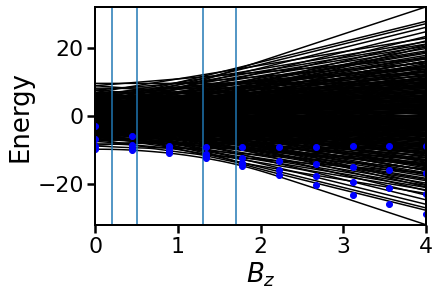

In [193]:
eightsitesexperiments(Bzmax = 4, write = True)

In [47]:
def eightsitesexperiments_plot1(fig,ax):
    N=8
    Bzlist_training = [ 0.2, 0.5, 1.3]
    filename_exact = "BasisComp_Exact_energyN=8_npoints=100.dat"    
    Bzlist,eval_stor = read_plotdata_lcu_exactenergy(filename = filename_exact,ncol=2**N+1)
    
    for j in range(2**N):
        if(j==0):
            ax.plot(Bzlist,eval_stor[:,j],color="k",lw=2) 
        else:
            ax.plot(Bzlist,eval_stor[:,j],color="k",alpha=0.1) 
    filename_ed = "BasisComp_ed_energyN=8"+str(Bzlist_training)+"lentarget=10.dat"
    Bzlist_ed,eval_stor_ed = read_plotdata_lcu_exactenergy(filename = filename_ed,ncol=len(Bzlist_training)+1)
    for j in range(len(Bzlist_training)):
        if(j==0):
            ax.plot(Bzlist_ed,eval_stor_ed[:,j],color="b",marker="o",markersize=4,label="EC") 
        else:
            ax.plot(Bzlist_ed,eval_stor_ed[:,j],color="b",marker="o",markersize=4,alpha=0.1) 
    ################################
    
    filename_BCtr = "BasisComp_trainingN="+str(N)+str(Bzlist_training)+".dat"        
    Bzlist_tr, Elisttr = read_plotdata_lcu_train(filename=filename_BCtr,ncol=2)
    # ax.plot(Bzlist_tr,Elisttr,'s',color = "r",fillstyle = "left",markersize = 10,label = "Training points")
    ax.plot(Bzlist_tr,Elisttr,'s',color = "r",fillstyle = "left",markersize = 10,)
    
    ymin, ymax = ax.get_ybound()
    for j in range(len(Bzlist_tr)):
        ax.axvline(Bzlist_tr[j],ymax = (Elisttr[j]-ymin)/(ymax-ymin),ymin=0.09,ls="--",color="r")
        ax.text(Bzlist_tr[j]-0.2,-31.0,str(Bzlist_tr[j]), fontsize='15')
    # ax.text(Bzlist_tr[1]-0.1,-22.0,str(Bzlist_tr[1]), fontsize='15')
    # ax.text(Bzlist_tr[2],-20.5, str(Bzlist_tr[2]),fontsize='15')
    #####################################
    filename_BcCr = "BasisComp_crossingN="+str(N)+".dat"        
    filename_BcCr = "paper_figures/plot_data/" + filename_BcCr
    data = np.genfromtxt(filename_BcCr)
    data = data.T
    # print(data)
    crossings = data
    print(crossings)
    col1=(0.0,0.5,0.5,0.05)
    col2=(0.0,0.5,0.5,0.1)
    col3=(0.0,0.5,0.5,0.2)
    col4=(0.0,0.5,0.5,0.3)
    col5=(0.0,0.5,0.5,0.4)
    # ax.axvspan(0.0, crossings[1], facecolor=col1)
    # ax.axvspan(crossings[1], crossings[2], facecolor=col2)
    # ax.axvspan(crossings[2], 6.0, facecolor=col3)
    ax.axvspan(0.0, crossings[0], facecolor=col1)
    ax.axvspan(crossings[0], crossings[1], facecolor=col2)
    ax.axvspan(crossings[1], crossings[2], facecolor=col3)
    ax.axvspan(crossings[2], crossings[3], facecolor=col4)
    ax.axvspan(crossings[3], 4.0, facecolor=col5)
    l=ax.legend(loc=2,fontsize=12)
    l.get_frame().set_alpha(0)
    
    fig.text(-0.05, 0.5, r"$ Energy[J] $", va='center', ha='center', rotation='vertical', fontsize=plt.rcParams['axes.labelsize'])

In [48]:
def eightsitesexperiments_plot2(fig,ax):
    N=8
    Bzlist_training = [ 0.2, 0.5, 1.3,1.7]
    filename_exact = "BasisComp_Exact_energyN=8_npoints=100.dat"    
    Bzlist,eval_stor = read_plotdata_lcu_exactenergy(filename = filename_exact,ncol=2**N+1)
    
    for j in range(2**N):
        if(j==0):
            ax.plot(Bzlist,eval_stor[:,j],color="k",lw=2) 
        else:
            ax.plot(Bzlist,eval_stor[:,j],color="k",alpha=0.1) 
    filename_ed = "BasisComp_ed_energyN=8"+str(Bzlist_training)+"lentarget=10.dat"
    Bzlist_ed,eval_stor_ed = read_plotdata_lcu_exactenergy(filename = filename_ed,ncol=len(Bzlist_training)+1)
    for j in range(len(Bzlist_training)):
        if(j==0):
            ax.plot(Bzlist_ed,eval_stor_ed[:,j],color="b",marker="o",markersize=4,label="EC") 
        else:
            ax.plot(Bzlist_ed,eval_stor_ed[:,j],color="b",marker="o",markersize=4,alpha=0.3) 
    ################################
    
    filename_BCtr = "BasisComp_trainingN="+str(N)+str(Bzlist_training)+".dat"        
    Bzlist_tr, Elisttr = read_plotdata_lcu_train(filename=filename_BCtr,ncol=2)
    # ax.plot(Bzlist_tr,Elisttr,'s',color = "r",fillstyle = "left",markersize = 10,label = "Training points")
    ax.plot(Bzlist_tr,Elisttr,'s',color = "r",fillstyle = "left",markersize = 10,)
    
    ymin, ymax = ax.get_ybound()
    for j in range(len(Bzlist_tr)):
        ax.axvline(Bzlist_tr[j],ymax = (Elisttr[j]-ymin)/(ymax-ymin),ymin=0.09,ls="--",color="r")
        ax.text(Bzlist_tr[j]-0.2,-31.0,str(Bzlist_tr[j]), fontsize='15')
    # ax.text(Bzlist_tr[1]-0.1,-22.0,str(Bzlist_tr[1]), fontsize='15')
    # ax.text(Bzlist_tr[2],-20.5, str(Bzlist_tr[2]),fontsize='15')
    #####################################
    filename_BcCr = "BasisComp_crossingN="+str(N)+".dat"        
    filename_BcCr = "paper_figures/plot_data/" + filename_BcCr
    data = np.genfromtxt(filename_BcCr)
    data = data.T
    # print(data)
    crossings = data
    print(crossings)
    col1=(0.0,0.5,0.5,0.05)
    col2=(0.0,0.5,0.5,0.1)
    col3=(0.0,0.5,0.5,0.2)
    col4=(0.0,0.5,0.5,0.3)
    col5=(0.0,0.5,0.5,0.4)
    ax.axvspan(0.0, crossings[0], facecolor=col1)
    ax.axvspan(crossings[0], crossings[1], facecolor=col2)
    ax.axvspan(crossings[1], crossings[2], facecolor=col3)
    ax.axvspan(crossings[2], crossings[3], facecolor=col4)
    ax.axvspan(crossings[3], 4.0, facecolor=col5)
    l=ax.legend(loc=2,fontsize=12)
    l.get_frame().set_alpha(0)
    
    fig.text(-0.05, 0.5, r"$ Energy[J] $", va='center', ha='center', rotation='vertical', fontsize=plt.rcParams['axes.labelsize'])

In [49]:
def eightsitesexperiments_plot3(fig,ax):
    N=8
    Bzlist_training = [ 0.2, 0.5, 1.3,1.7, 1.9]
    filename_exact = "BasisComp_Exact_energyN=8_npoints=100.dat"    
    Bzlist,eval_stor = read_plotdata_lcu_exactenergy(filename = filename_exact,ncol=2**N+1)
    
    for j in range(2**N):
        if(j==0):
            ax.plot(Bzlist,eval_stor[:,j],color="k",lw=2) 
        else:
            ax.plot(Bzlist,eval_stor[:,j],color="k",alpha=0.1) 
    filename_ed = "BasisComp_ed_energyN=8"+str(Bzlist_training)+"lentarget=10.dat"
    Bzlist_ed,eval_stor_ed = read_plotdata_lcu_exactenergy(filename = filename_ed,ncol=len(Bzlist_training)+1)
    for j in range(len(Bzlist_training)):
        if(j==0):
            ax.plot(Bzlist_ed,eval_stor_ed[:,j],color="b",marker="o",markersize=4,label="EC") 
        else:
            ax.plot(Bzlist_ed,eval_stor_ed[:,j],color="b",marker="o",markersize=4,alpha=0.3) 
    ################################
    
    filename_BCtr = "BasisComp_trainingN="+str(N)+str(Bzlist_training)+".dat"        
    Bzlist_tr, Elisttr = read_plotdata_lcu_train(filename=filename_BCtr,ncol=2)
    # ax.plot(Bzlist_tr,Elisttr,'s',color = "r",fillstyle = "left",markersize = 10,label = "Training points")
    ax.plot(Bzlist_tr,Elisttr,'s',color = "r",fillstyle = "left",markersize = 10,)
    
    ymin, ymax = ax.get_ybound()
    for j in range(len(Bzlist_tr)-1):
        ax.axvline(Bzlist_tr[j],ymax = (Elisttr[j]-ymin)/(ymax-ymin),ymin=0.09,ls="--",color="r")
        ax.text(Bzlist_tr[j]-0.2,-31.0,str(Bzlist_tr[j]), fontsize='15')
    # ax.axvline(Bzlist_tr[3],ymax = (Elisttr[j]-ymin)/(ymax-ymin),ymin=0.09,ls="--",color="r")
    # ax.text(Bzlist_tr[3]-0.23,-31.0,str(Bzlist_tr[3]), fontsize='15')
    ax.axvline(Bzlist_tr[4],ymax = (Elisttr[j]-ymin)/(ymax-ymin),ymin=0.09,ls="--",color="r")
    ax.text(Bzlist_tr[4]-0.1,-31.0,str(Bzlist_tr[4]), fontsize='15')
    
    #####################################
    filename_BcCr = "BasisComp_crossingN="+str(N)+".dat"        
    filename_BcCr = "paper_figures/plot_data/" + filename_BcCr
    data = np.genfromtxt(filename_BcCr)
    data = data.T
    # print(data)
    crossings = data
    print(crossings)
    col1=(0.0,0.5,0.5,0.05)
    col2=(0.0,0.5,0.5,0.1)
    col3=(0.0,0.5,0.5,0.2)
    col4=(0.0,0.5,0.5,0.3)
    col5=(0.0,0.5,0.5,0.4)
    ax.axvspan(0.0, crossings[0], facecolor=col1)
    ax.axvspan(crossings[0], crossings[1], facecolor=col2)
    ax.axvspan(crossings[1], crossings[2], facecolor=col3)
    ax.axvspan(crossings[2], crossings[3], facecolor=col4)
    ax.axvspan(crossings[3], 4.0, facecolor=col5)
    l=ax.legend(loc=2,fontsize=12)
    l.get_frame().set_alpha(0)
    
    fig.text(-0.05, 0.5, r"$ Energy[J] $", va='center', ha='center', rotation='vertical', fontsize=plt.rcParams['axes.labelsize'])

/home/akhil/anaconda3/envs/h2/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  This is separate from the ipykernel package so we can avoid doing imports until


[0.344689 1.002004 1.531062 1.875752]
[0.344689 1.002004 1.531062 1.875752]
[0.344689 1.002004 1.531062 1.875752]


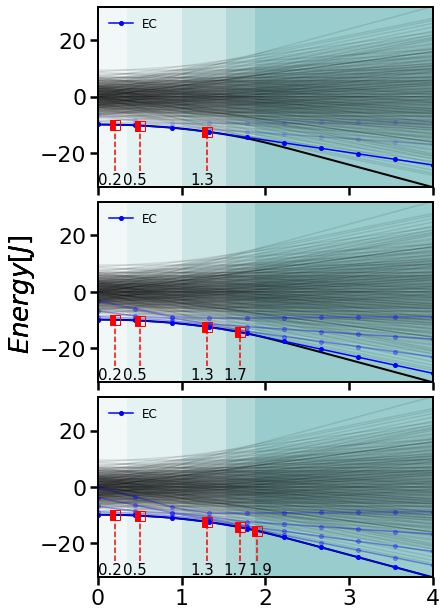

In [53]:
def eightsitesexperiments_plot_tog():
    fig,ax = plt.subplots(figsize=(6,3.5*3),nrows =3,ncols=1,sharex=True)
    fig.subplots_adjust(wspace=0.0,hspace=0.08)
    eightsitesexperiments_plot1(fig=fig,ax=ax[0])    
    eightsitesexperiments_plot2(fig=fig,ax=ax[1]) 
    eightsitesexperiments_plot3(fig=fig,ax=ax[2]) 
    tag = "N=8BS_v1"
    fignamepdf = "paper_figures/paper_plots/" + tag + ".pdf"
    fig.savefig(fignamepdf,bbox_inches='tight')
    fignamepng = "paper_figures/paper_plots/" + tag + ".png"
    fig.savefig(fignamepng,bbox_inches='tight')
eightsitesexperiments_plot_tog()